# Very early BETA version

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold
from itertools import combinations
from sklearn.feature_selection import SelectKBest, f_classif
from scipy import stats
import missingno as msno

# Inital inspection and setting up a basic pipeline

In [2]:
df = pd.read_csv('AmesHousing.tsv', delimiter="\t")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


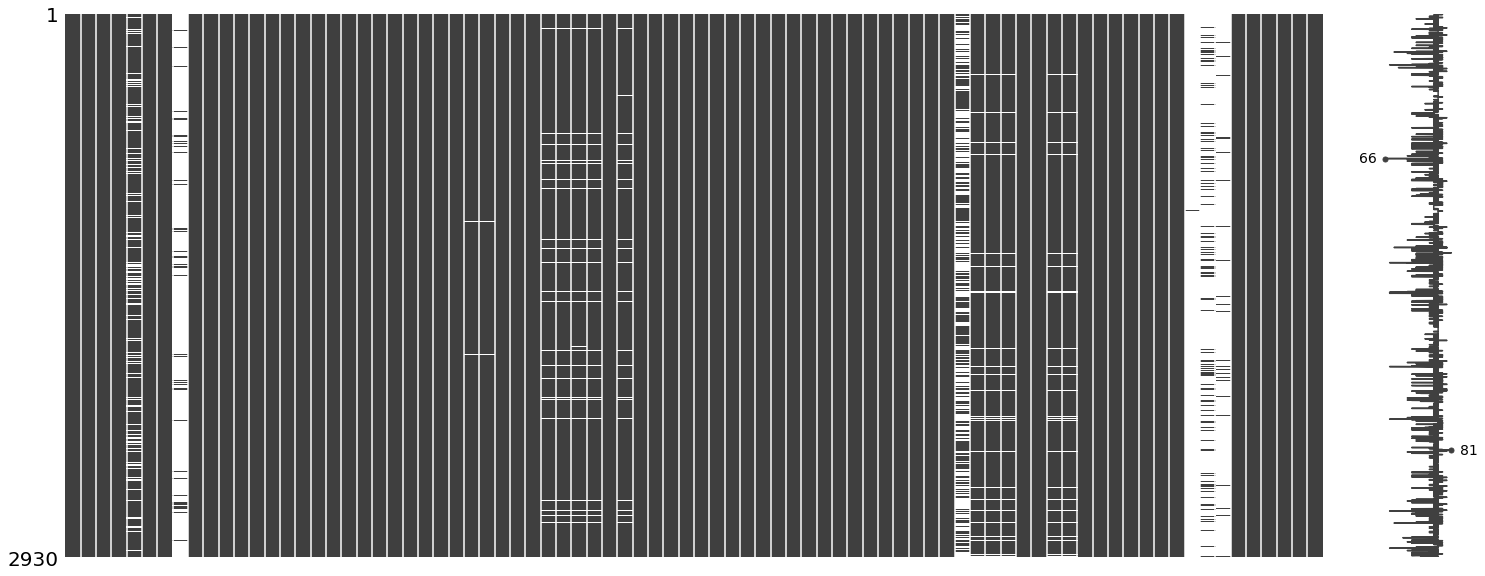

In [3]:
msno.matrix(df)
plt.show()

In [4]:
df.isnull().sum().sort_values(ascending=False)[:10]

Pool QC          2917
Misc Feature     2824
Alley            2732
Fence            2358
Fireplace Qu     1422
Lot Frontage      490
Garage Cond       159
Garage Finish     159
Garage Yr Blt     159
Garage Qual       159
dtype: int64

In [5]:
df.corr()['SalePrice'].abs().sort_values(ascending=False)[:10]

SalePrice         1.000000
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Name: SalePrice, dtype: float64

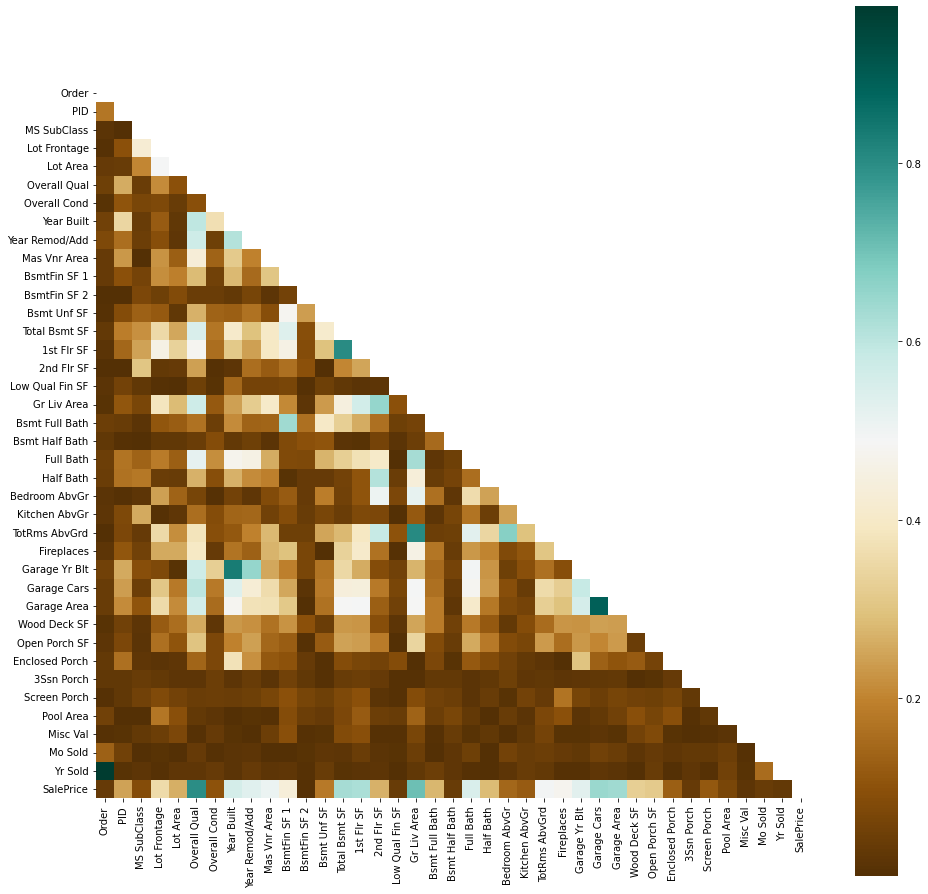

In [6]:
# lets generate a correlation heatmap:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(abs(df.corr()), square=True, cmap='BrBG', mask=mask)
plt.show()

**Observations:**
* multiple columns with nominal or continuos data that can be merged into a smaller number of columns 
* eg. there are at least 4 columns related to 'porch'

In [7]:
def transform_features(df):
    return df

def select_features(df):
    return df[['Overall Qual','SalePrice']]

def train_and_test(df):
    # split 50:50
    train = df[:1460].copy()
    test = df[1460:].copy()
    
    # numeric
    numeric_train = train.select_dtypes(include=['integer','float'])
    numeric_test = test.select_dtypes(include=['integer','float'])
    
    # train
    features = numeric_train.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    return rmse

# lets create a pipeline function, so  we can just replace names of the input functions to test out the new changes
def pipeline(df=df, t=transform_features, s=select_features, r=train_and_test):
    transform = t(df)
    selected = s(transform)
    rmse = r(selected)
    return rmse
pipeline()

49492.23698000454

# update column cleaning (include dropping text cols)

In [8]:
def transform_features2(df):
    
    # VERSION 2 change: (handling null values in text):   
    null_count = (df.isnull().sum() / len(df))
    df = df[null_count[null_count<0.05].index]
    df = df.fillna(df.select_dtypes(include=['integer','float']).mean())
    
    null_count = df.select_dtypes(include=['object']).isnull().sum()
    textic2_drop = null_count[null_count > 0].index
    df = df.drop(textic2_drop,axis=1) 

    # lets create an age column and filter out rows with negative value:
    df['age'] = df['Yr Sold'] - df['Year Built']
    df = df[df['age'] >= 0]
    
    # lets create a yrs remod column and filter out rows with negative value: 
    df['yrs remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df = df[df['yrs remod'] >= 0]
   
    # drop the year cols:
    df = df.drop(["Year Built", "Year Remod/Add", 'Yr Sold', 'PID', "Order", 'Sale Type', 'Sale Condition',"Mo Sold"], axis = 1)
    return df



# test different feature selection algos

In [9]:
# transform based on corr matrix:
def select_features2(df):
    abs_corr_coeffs = df.corr()['SalePrice'].abs().sort_values(ascending=False)
    cols = abs_corr_coeffs[abs_corr_coeffs > 0.4].index.tolist()
    df = df[cols]
    return df

pipeline(t=transform_features2,s=select_features2)

36636.25030174907

In [10]:
transformed = transform_features2(df)
%timeit select_features2(transformed)

11.6 ms ± 979 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
# transform based on SelectKBest:
def select_features2v2(df):
    numeric_df2 = df.select_dtypes(include=['integer','float'])
    # how many to numeric cols we want to keep?
    numeric_df2 = numeric_df2.drop('SalePrice',axis=1)
    numeric_df2['SalePrice'] = df['SalePrice']
    # how many to numeric cols we want to keep?
    predictors = numeric_df2.columns.tolist()[:-1]
    # Perform feature selection
    selector = SelectKBest(f_classif, k=5)
    selector.fit(numeric_df2[predictors], numeric_df2['SalePrice'])
    # Get the raw p-values for each feature, and transform from p-values into scores
    scores = -np.log10(selector.pvalues_)
    res_frame = pd.DataFrame([predictors,scores]).transpose().sort_values(1,ascending=False)
    res_frame.reset_index(inplace=True)
    res_frame = res_frame.drop('index',axis=1)
    cols = res_frame[0][:14].values.tolist()
    df2 = numeric_df2[cols].copy()
    df2['SalePrice'] = df['SalePrice']
    return df2

pipeline(t=transform_features2,s=select_features2v2)

36669.91992387276

In [12]:
transformed = transform_features2(df)
%timeit select_features2v2(transformed)

128 ms ± 22.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Observations:**

The difference in results is very small, we'll choose the first solution. It delivers slightly better results and does that with **only 3 lines of code and 10 times faster.** 

# update select features - dummies

In [13]:
def col_dummy(df, col):
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes
    hood_series = pd.get_dummies(df[col],prefix=col)
    df = pd.concat([df, hood_series], axis=1)
    df = df.drop(columns=(col), axis=1)
    return df

In [14]:
categorical_no_leaks = [ "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature"]

categorical_no_leaks2 = []
for col in categorical_no_leaks:
    # adjust to 8
    if (col in df.columns) & (df[col].value_counts().shape[0]>10):
        categorical_no_leaks2.append(col)


def select_features3(df, corr=0.4):
    abs_corr_coeffs = df.corr()['SalePrice'].abs().sort_values(ascending=False)
    # adjust this one to 0.1:
    cols = abs_corr_coeffs[abs_corr_coeffs > corr].index.tolist()
    df2 = df[cols].copy()
    for col in categorical_no_leaks2:
        if col in df.columns:
            df2[col] = df[col]
            df2 = col_dummy(df2,col)
            

    return df2

pipeline(t=transform_features2,s=select_features3)

32885.6040324598

# update train and test

In [15]:
def train_and_test2(df, k=5, r=1):
    if k in range(2,101):
        numeric_df = df.select_dtypes(include=['integer', 'float'])
        features = numeric_df.columns.drop("SalePrice")
        lr = linear_model.LinearRegression()

        kf = KFold(n_splits=k, shuffle=True, random_state=r)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
            avg_rmse = np.mean(rmse_values)
        return avg_rmse
    else:
        print("Naah mate need a different number, something 'integerry' and bigger than 1 and below a 100, mate! cheers")

    
rmse = pipeline(t=transform_features2,s=select_features3, r=train_and_test2)
rmse    

29327.856878951097

# Improving results 

In [16]:
def spines(ax,yl='RMSE',xl='Random seed'):
    x1 = ax.spines['right'].set_visible(False)
    x2 = ax.spines['top'].set_visible(False)
    x3 = ax.spines['left'].set_linewidth(2)
    x4 = ax.spines['bottom'].set_linewidth(2)
    x5 = ax.set_ylabel(yl)
    x6 = ax.set_xlabel(xl)
    return x1, x2, x3, x4, x5, x6

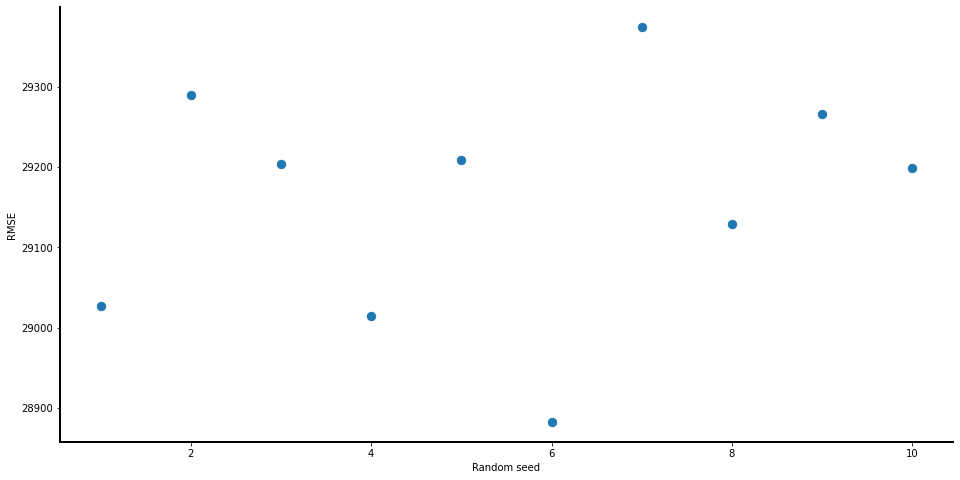

Average rmse result of 10 random seeds:  29159.78662287094
which equals to:  16.12855203363485  percent of avg house price in the original dataset


In [17]:
transform_df = transform_features2(df)
filtered_df = select_features3(transform_df)
k_fold_random1 = []
n_list = list(range(1,11))

for n in n_list:
    rmse= train_and_test2(filtered_df, k=10, r=n)
    k_fold_random1.append(rmse)

fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(n_list, k_fold_random1, s=70)
spines(ax)
plt.show()

print('Average rmse result of 10 random seeds: ',np.mean(k_fold_random1))
print('which equals to: ', 
      np.mean(k_fold_random1)/ df['SalePrice'].mean() *100,' percent of avg house price in the original dataset')

In [18]:
abs(df.corr()['SalePrice']).sort_values(ascending=False)[:35]

SalePrice          1.000000
Overall Qual       0.799262
Gr Liv Area        0.706780
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
PID                0.246521
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Enclosed Porch     0.128787
Kitchen AbvGr      0.119814
Screen Porch       0.112151
Overall Cond       0.101697
MS SubClass        0.085092
Pool Area          0.068403
Low Qual Fin SF    0.037660
Bsmt Half Bath     0.035835
Mo Sold            0.035259
3Ssn Porch         0.032225
Name: SalePrice, dty

# Feature engineering part 1.
At this stage we'll commence an art of subtle engineering, the best guidance I've found online is a [post](https://towardsdatascience.com/feature-engineering-and-ensembled-models-for-the-top-10-in-kaggle-housing-prices-competition-efb35828eef0) made by one of the top kagglers. To quote a very important section from his post:

>Combining data / simplifying the model — that’s what I use a lot. The world is not that complicated. In this case, it seems to me that 3 features would be enough — how big the house is?, how nice it is? how comfortable is it?

The above link leads to an article on towardsdatascience.com, link to original post: [link](https://www.kaggle.com/c/home-data-for-ml-course/discussion/100526#652503)

Combining data seems like an easy option for now - lets try it. We'll merge columns in different ways, for now lets start with an easy merging of features and their quality. We can see a repetitive pattern in some columns:
* numeric column with amount(or area) of features (say number of kitchens)
* categorical column with quality of features (quality scale: 'Po', 'Fa', 'TA', 'Gd', 'Ex')
* we'll transform the quality column into numbers and multiply it by amount of features
    * while doing that will raise the quality number to a power of our own deciding (the idea is: quality of kitchen should be more important and price influencing than the quality of garage) 

In [19]:
def quality_area(data2,phrase,col1,col2, weight):
    # look up all 'keyword' columns:
    phrase_cols = [col for col in data2.columns if phrase in col]
    data2['quality'] = data2[col1].map({None: 1, "Po": 2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    # change nulls to 1:
    data2.loc[data2["quality"].isnull(), "quality"] = 1
    data2[phrase+'_all'] = data2[col2] * (data2["quality"]**weight)
    data2 = data2.drop(columns=phrase_cols+["quality"], axis=1)
    return data2

dff=df.copy()

# Now lets use this function to merge all columns that relate to:
# 1. fireplace
df_q1 = quality_area(dff,'Fireplace','Fireplace Qu','Fireplaces',5)
# 2. kitchen:
df_q1 = quality_area(df_q1,'Kitchen','Kitchen Qual','Kitchen AbvGr',10)
# 3. garage
df_q1 = quality_area(df_q1,'Garage','Garage Cond','Garage Area',1)
# 4. pool and... - lets try adding one more column to 'Pool_all' column
df_q1 = quality_area(df_q1,'Pool','Pool QC','Pool Area',1)
df_q1['Pool_all'] = df_q1['Pool_all']+df_q1['Misc Val']
df_q1 = df_q1.drop(columns=['Misc Val'])

rmse = pipeline(df=df_q1,t=transform_features2,s=select_features3, r=train_and_test2)
rmse  

28147.243979719664

# Feature engineering part 2.

In [20]:
df.groupby('Roof Style')['SalePrice'].mean()

Roof Style
Flat       184798.500000
Gable      170311.854373
Gambrel    138284.954545
Hip        226689.517241
Mansard    166225.363636
Shed       193200.000000
Name: SalePrice, dtype: float64

After doing the first part of feature engineering our rmse results lowered - we're on the right track. We'll continue with a modified approach. General idea stays the same: merge multiple columns related to the same topic into 1 column (call it captain planet). However it gets a bit trickier at this stage:

* they're categorical columns so we can't just add or multiply their values
* instead we'll group the dataset by the current column(eg.'Roof Style') and get average house price values per roof style
    * we'll do the same for every 'roof' column
    * then we'll either add or multiply all those values to create one unified 'roof' column
    * we'll repeat the process for other features
    * it's important to pay attention to type of columns - mapping columns with continuos values would create data leaks


In [21]:
def merging_data(cols_list):
    d_list = []
    for el in cols_list:
        d = df_q2.groupby(el)['SalePrice'].mean().sort_values().to_dict()
        d_list.append(d)
    return d_list, cols_list
df_q2 = df_q1.copy()

# Roof: 
dl,dl1 = merging_data(['Roof Style', 'Roof Matl'])
df_q2['roofs'] = df_q2['Roof Style'].map(dl[0]) + df_q2['Roof Matl'].map(dl[1])**2

# street: 
dl,dl2 = merging_data(['Street', 'Alley', 'Paved Drive'])
df_q2['streets'] = df_q2['Street'].map(dl[0]) + df_q2['Alley'].map(dl[1]) + df_q2['Paved Drive'].map(dl[2])

# basement:
dl,dl3 = merging_data(['Bsmt Qual','Bsmt Exposure','Bsmt Cond'])
df_q2['base_all'] = (df_q2['Bsmt Qual'].map(dl[0]) + df_q2['Bsmt Exposure'].map(dl[1]) + df_q2['Bsmt Cond'].map(dl[2])) * df_q2['Total Bsmt SF']

# exterior:
dl,dl4 = merging_data(['Exter Qual', 'Exter Cond', 'Exterior 1st', 'Exterior 2nd', 
                            'Mas Vnr Type', 'Foundation'])
df_q2['exterior'] = (df_q2['Exter Qual'].map(dl[0])*2 + df_q2['Exter Cond'].map(dl[1]) + df_q2['Exterior 1st'].map(dl[2]) 
+ df_q2['Exterior 2nd'].map(dl[3]) + df_q2['Foundation'].map(dl[5]) + df_q2['Mas Vnr Type'].map(dl[4])) * df_q2['Mas Vnr Area']  

# heating, AC
dl, dl5 = merging_data(['Heating', 'Heating QC', 'Central Air'])
df_q2['heating'] = df_q2['Heating'].map(dl[0]) + df_q2['Heating QC'].map(dl[1]) + df_q2['Central Air'].map(dl[2])

df_q2 = df_q2.drop(columns=dl1 + dl2 + dl3 + dl4 + dl5 + ['Mas Vnr Area', 'Total Bsmt SF' ])

rmse = pipeline(df=df_q2,t=transform_features2,s=select_features3, r=train_and_test2)
rmse  

27516.91288183034

**Bathrooms and porch columns:**
* add full bathrooms and half bathrooms together (full bathrooms are more important so lets raise that number to the power of...x, then add to half bathrooms)
* porch columns contain area values - add all of them together

In [22]:
df_q3 = df_q2.copy()

# bathrooms:
df_q3['bath_count'] = df_q3['Full Bath']**3 + (df_q3['Half Bath']) 
df_q3 = df_q3.drop(columns=['Full Bath', 'Half Bath'], axis=1)

# porch
porch_cols = [col for col in df_q3.columns if 'Porch' in col]
df_q3['total_porch'] = df_q3[porch_cols].sum(axis=1) + df_q3['Wood Deck SF']
df_q3= df_q3.drop(columns=porch_cols+['Wood Deck SF'], axis=1)

rmse = pipeline(df=df_q3,t=transform_features2,s=select_features3, r=train_and_test2)
rmse

27395.020458067353

**Merging house area and its quality**

In [23]:
df_q4 = df_q3.copy()

df_q4= df_q4.drop(columns=['Utilities', 'Condition 1','Bldg Type', 'BsmtFin SF 2','Bsmt Unf SF', 'Bsmt Full Bath',
                          'Bsmt Half Bath', 'BsmtFin Type 1', 'BsmtFin Type 2'], axis=1)

df_q4['livin_qa'] = df_q4['Gr Liv Area'] * (df_q4["Overall Qual"])
df_q4 = df_q4.drop(columns=['Gr Liv Area',"Overall Qual"], axis=1)

rmse = pipeline(df=df_q4,t=transform_features2,s=select_features3, r=train_and_test2)
rmse

26967.737872064532

In [24]:
transform_df = transform_features2(df_q4)
filtered_df = select_features3(transform_df, corr=0.1)
rmse = train_and_test2(filtered_df, k=4)
rmse

26220.625620918414

In [25]:
lot_cols = [col for col in df_q4.columns if 'Lot' in col]
lot_cols.pop(1)
lot_cols.pop(0)
df_q4= df_q4.drop(columns=lot_cols+['Fence'], axis=1)

land_cols = [col for col in df_q4.columns if 'Land' in col]
dl,dl6 = merging_data(land_cols)
df_q4['land_all'] = df_q4[land_cols[0]].map(dl[0]) + df_q4[land_cols[1]].map(dl[1])
df_q4= df_q4.drop(columns=land_cols, axis=1)
df_q4= df_q4.drop(columns=['1st Flr SF', '2nd Flr SF','TotRms AbvGrd'], axis=1)

transform_df = transform_features2(df_q4)
filtered_df = select_features3(transform_df, corr=0.1)
rmse = train_and_test2(filtered_df, k=4)
rmse

26030.1531707662

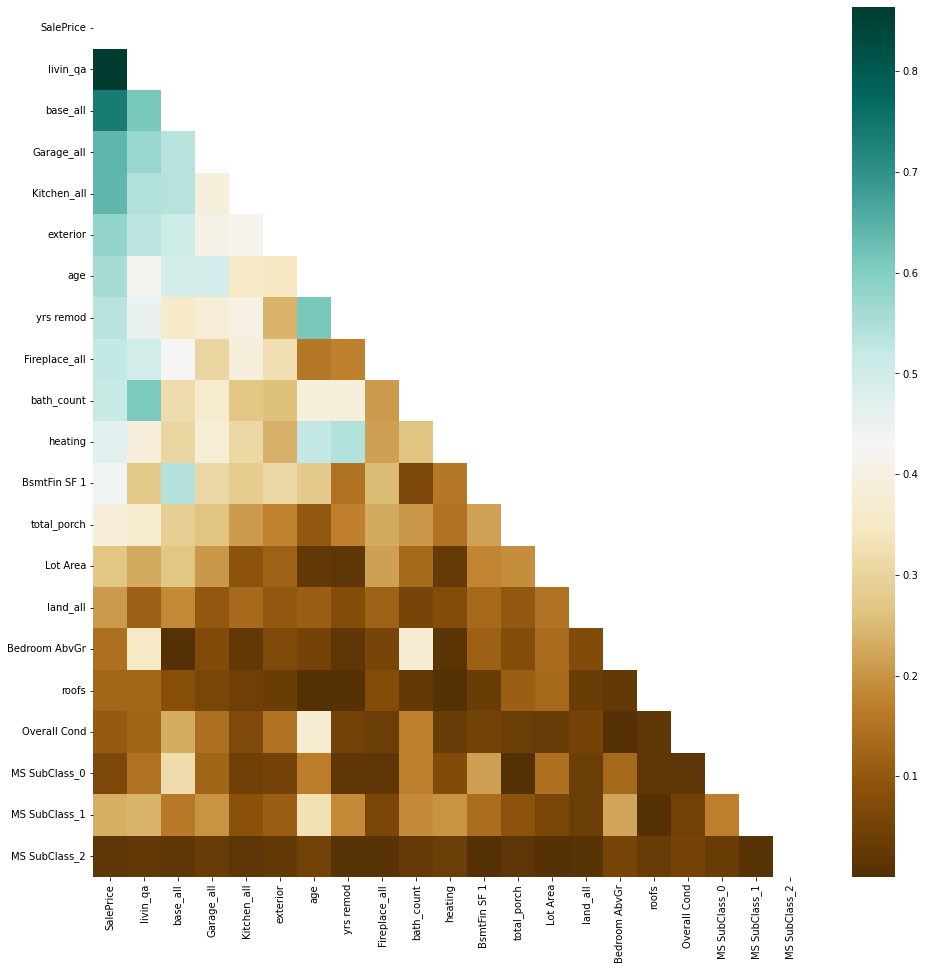

In [26]:
mask = np.triu(np.ones_like(filtered_df.iloc[:,:21].corr(), dtype=bool))
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(abs(filtered_df.iloc[:,:21].corr()),cmap='BrBG',  mask=mask)
plt.show()

In [27]:
top5_corrs = abs(filtered_df.corr()['SalePrice']).sort_values(ascending=False)[:5]
top5_corrs

SalePrice      1.000000
livin_qa       0.863692
base_all       0.737536
Garage_all     0.643596
Kitchen_all    0.640099
Name: SalePrice, dtype: float64

In [28]:
def train_and_test3(df, k=5, r=1):
    if k in range(2,101):
        numeric_df = df.select_dtypes(include=['integer', 'float'])
        features = numeric_df.columns.drop("SalePrice")
        lr = linear_model.LinearRegression()

        kf = KFold(n_splits=k, shuffle=True, random_state=r)
        rmse_values = []
        df_list = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            test2 = test.copy()
            test2['predicted'] = predictions
            df_list.append(test2)
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
            res_df = pd.concat(df_list, axis=0)
            res_df = res_df.sort_values('SalePrice')
            res_df = res_df.reset_index()
            res_df = res_df.drop(columns='index')
            avg_rmse = np.mean(rmse_values)
        return avg_rmse, res_df
    else:
        print("Naah mate need a different number, something 'integerry' and bigger than 1 and below a 100, mate! cheers")  
rmse, results_df = pipeline(df=df_q4 ,t=transform_features2,s=select_features3, r=train_and_test3)   

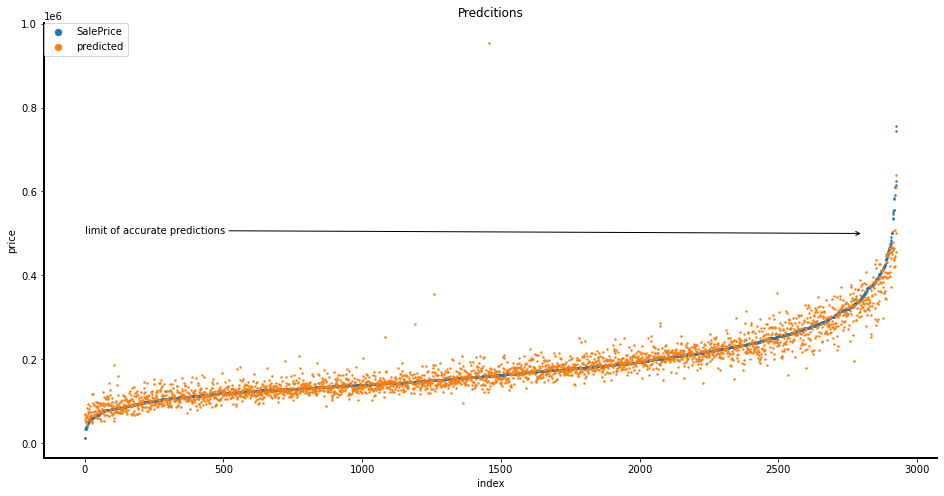

In [29]:
fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(results_df.index, results_df['SalePrice'], s=2, label='SalePrice')
plt.scatter(results_df.index, results_df['predicted'], s=2, label='predicted')
spines(ax,yl='price',xl='index')
plt.title('Predcitions')
ax.annotate("limit of accurate predictions", xy=(2805, 500000), xytext=(0, 500000), arrowprops=dict(arrowstyle="->"))

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles, labels, loc=2, borderaxespad=0)
for el in l.legendHandles:
    el._sizes = [40]
plt.show()

**Amount of predictions with an error bigger than 50 000 USD:**

In [30]:
len(results_df[results_df['predicted'] - results_df['SalePrice'] > 50000])

47


# Remove outliers
We'll compare 2 diffrent methods:
IQR or Z score

[link](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba) to an article about outlier removal.

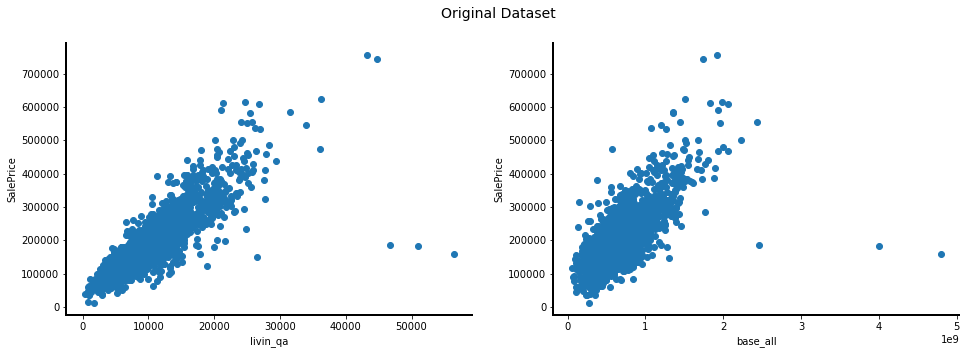

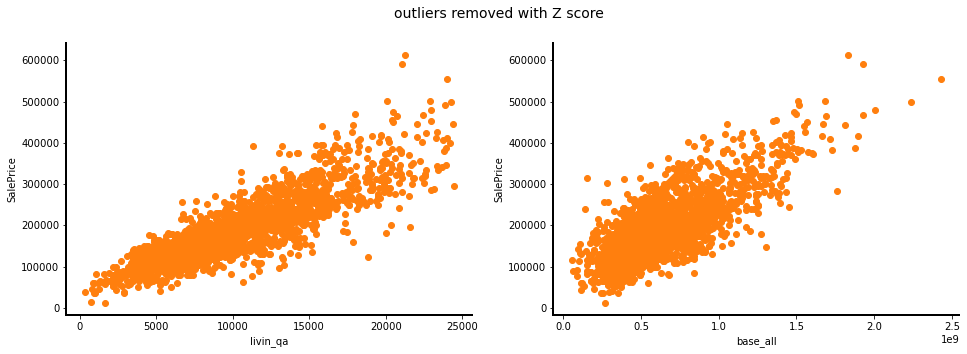

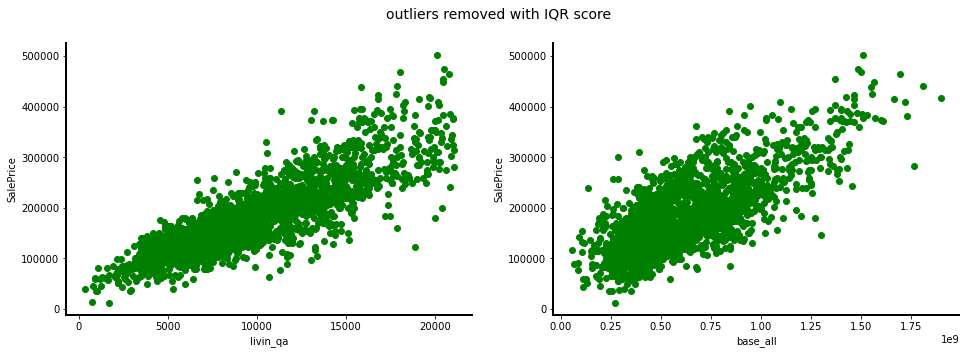

In [31]:
def iqring(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df2 = df[~((df[col] < (Q1 - 1.5 * IQR)) |(df[col] > (Q3 + 1.5 * IQR)))]
    return df2

from scipy import stats
# Z score
z = np.abs(stats.zscore(df_q4['livin_qa']))
threshold = 3
np.where(z > 3)
df_test1 = df_q4[(z < 3)]

# IQR method:
Q1 = df_q4["livin_qa"].quantile(0.25)
Q3 = df_q4["livin_qa"].quantile(0.75)
IQR = Q3 - Q1
df_test2 = df_q4[~((df_q4["livin_qa"] < (Q1 - 1.5 * IQR)) |(df_q4["livin_qa"] > (Q3 + 1.5 * IQR)))]

def scatters(df, title, c='#1f77b4'):    
    fig, x1 = plt.subplots(1,2,figsize=(16,5))
    fig.suptitle(title, size=14)
    x2 = plt.subplot(121)
    x3 = plt.scatter(df["livin_qa"], df["SalePrice"], c=c)
    x4 = plt.subplot(122)
    x5 = plt.scatter(df["base_all"], df["SalePrice"], c=c)
    spines(x2, xl='livin_qa', yl='SalePrice')
    spines(x4, xl='base_all', yl='SalePrice')
    return fig, x1,x2,x3,x4,x5

scatters(df_q4,'Original Dataset')
plt.show()
scatters(df_test1,'outliers removed with Z score', c='#ff7f0e')
plt.show()
scatters(df_test2,'outliers removed with IQR score', c='green')


plt.show()

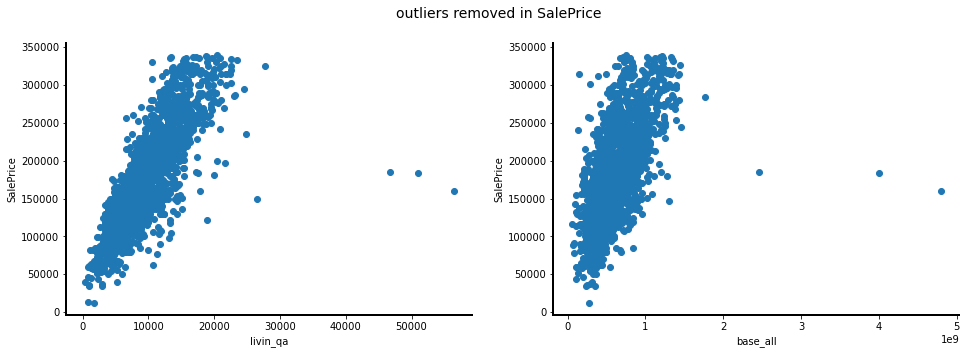

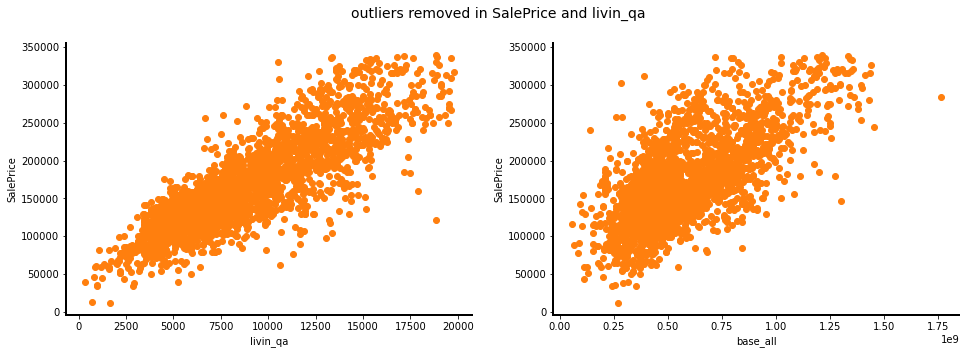

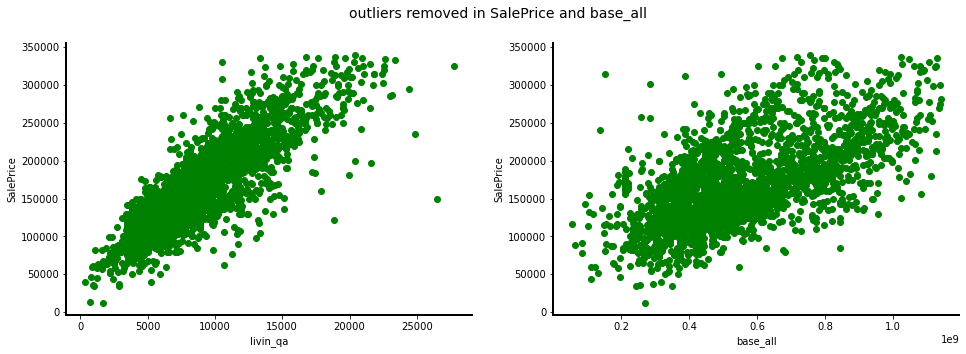

In [32]:
df_2iqr = iqring(df_q4, 'SalePrice')
df_3iqr = iqring(df_2iqr, 'livin_qa')
df_3iqrv2 = iqring(df_2iqr, 'base_all')

scatters(df_2iqr,'outliers removed in SalePrice')
plt.show()
scatters(df_3iqr,'outliers removed in SalePrice and livin_qa', c='#ff7f0e')
plt.show()
scatters(df_3iqrv2,'outliers removed in SalePrice and base_all', c='green')
plt.show()


In [33]:
transform_df = transform_features2(df_3iqr)
filtered_df = select_features3(transform_df, corr=0.01)
rmse = train_and_test2(filtered_df, k=10)
rmse

17333.892511384103

Average rmse result of 10 random seeds:  25578.109818484587
which equals to:  14.14749293144308  percent of avg house price in the original dataset
 
Average rmse result of 10 random seeds:  20068.162821242153
which equals to:  11.308075228341453  percent of avg house price in the original dataset
 
Average rmse result of 10 random seeds:  17348.428083195762
which equals to:  10.367553016818256  percent of avg house price in the original dataset
 


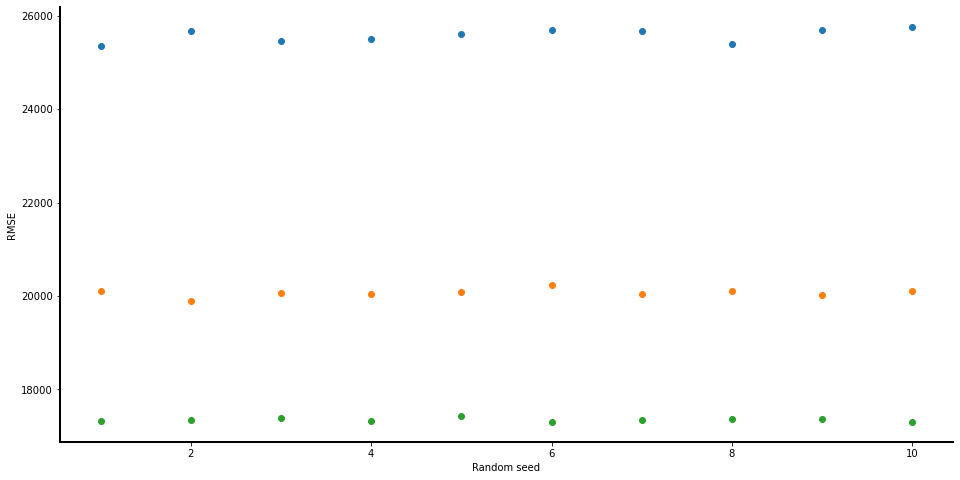

In [34]:
from scipy import stats
fig, ax = plt.subplots(figsize=(16,8))
df_list = [df_q4, df_test1, df_3iqr]
for df in df_list:
    transform_df = transform_features2(df)
    filtered_df = select_features3(transform_df, corr=0.01)
    k_fold_random1 = []
    n_list = list(range(1,11))
    for n in n_list:
        rmse= train_and_test2(filtered_df, k=10, r=n)
        k_fold_random1.append(rmse)
    print('Average rmse result of 10 random seeds: ',np.mean(k_fold_random1))
    print('which equals to: ', 
          np.mean(k_fold_random1)/ df['SalePrice'].mean() *100,' percent of avg house price in the original dataset')
    print(' ')    
    plt.scatter(n_list, k_fold_random1, label='Original dataset')
    spines(ax)
plt.show()

In [35]:
len(df_3iqrv2)

2709

In [36]:
transform_df = transform_features2(df_3iqrv2)

filtered_df = select_features3(transform_df, corr=0.01)

rmse, results_df = train_and_test3(filtered_df, k=10, r=1)
rmse

17104.60569218425

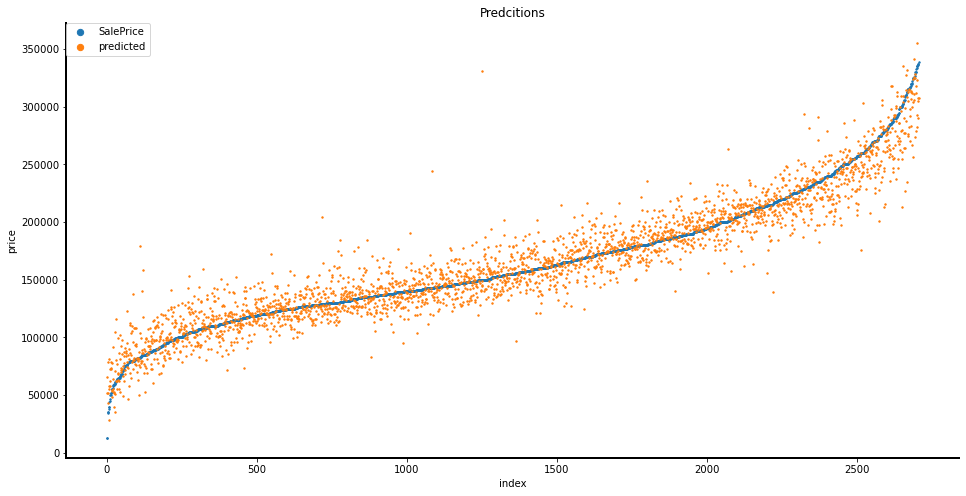

In [37]:
fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(results_df.index, results_df['SalePrice'], s=2, label='SalePrice')
plt.scatter(results_df.index, results_df['predicted'], s=2, label='predicted')
spines(ax,yl='price',xl='index')
plt.title('Predcitions')
# plt.legend()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles, labels, loc=2, borderaxespad=0)
for el in l.legendHandles:
    el._sizes = [40]
plt.show()

In [38]:
len(results_df[results_df['predicted'] - results_df['SalePrice'] > 50000])

19